In [21]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
import copy

In [9]:
# Read data 
real_data = np.loadtxt('real_observations.csv', delimiter=',')
description = np.loadtxt('observation_description.csv', delimiter=',',dtype='object')
param_values = 1/np.loadtxt('param_values.csv', delimiter=',')
func_eval = np.loadtxt('func_eval.csv', delimiter=',')
param_values_test = 1/np.loadtxt('param_values_test.csv', delimiter=',')
func_eval_test = np.loadtxt('func_eval_test.csv', delimiter=',')

In [10]:
print('N:', func_eval.shape[0])
print('P:', param_values.shape[1])
print('M:', real_data.shape[0])
print('D:', description.shape[1])

N: 2000
P: 10
M: 492
D: 2


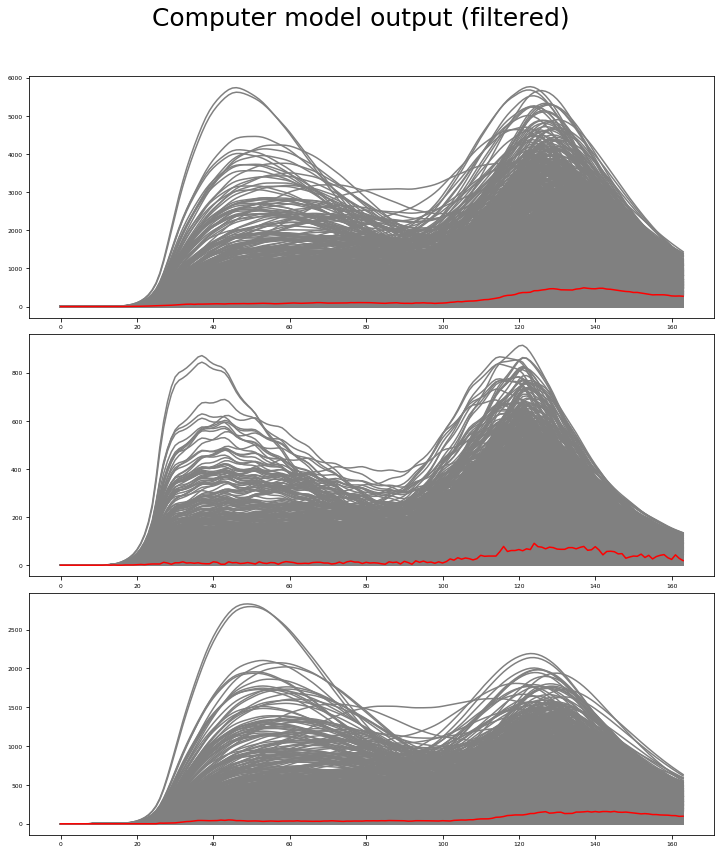

In [41]:
def plot_observed_data(description, func_eval, real_data, param_values, title = None):
    '''
    Plots a list of profiles in the same figure. Each profile corresponds
    to a stochastic replica for the given instance.
    '''
    plt.rcParams["font.size"] = "6"
    N = len(param_values)
    D = description.shape[1]
    T = len(np.unique(description[:,0]))
    type_no = len(np.unique(description[:,1]))
    fig, axs = plt.subplots(type_no, figsize=(10, 12))
    if title is not None:
        fig.suptitle(title, fontsize=25)
    for j in range(type_no):
        for i in range(N):
            axs[j].plot(range(T), func_eval[i,(j*T):(j*T + T)], color='grey')
        axs[j].plot(range(T), real_data[(j*T):(j*T + T)], color='red')
    fig.tight_layout()
    fig.subplots_adjust(top=0.9) 
    plt.show()
plot_observed_data(description, func_eval, real_data, param_values, title='Computer model output (filtered)')

In [19]:
stdobs = np.maximum(0.2*real_data, 5)  
feval = func_eval
obs = real_data 

# Scale early on, this type of scalling is not needed always
pcaoffset = obs
pcascale = stdobs
fstand = (feval/pcascale - pcaoffset/pcascale)
obsstand = (obs/pcascale - pcaoffset/pcascale)
    
# Do PCA
U, S, _ = np.linalg.svd(fstand.T, full_matrices = False)
    
# Keeping 10 PCs 
pcamat = U[:,0:10]
pcaweight = S[0:10]
pcamodel = fstand @ pcamat
print('Percentage of variance kept: ' + str(np.sum(S[0:10] ** 2)/np.sum(S ** 2)))

# Create a dictionary for the PCA model
pca_dict = {}
pca_dict['stdobs'] = stdobs
pca_dict['pcamodel'] = pcamodel
pca_dict['pcamat'] = pcamat
pca_dict['pcascale'] = pcascale
pca_dict['pcaoffset'] = pcaoffset
pca_dict['obsstand'] = obsstand
pca_dict['pcaobs'] = obsstand @ pcamat
pca_dict['varpcaobs'] = np.round(pcamat.T @ np.diag((stdobs **2) / (pcascale **2)) @ pcamat, 6)


Percentage of variance kept: 0.9999750356767447


In [22]:
current = os.path.abspath(os.getcwd())
sys.path.append(os.path.normpath(os.path.join(os.path.dirname(current), '..')))
from base.emulation import emulator

In [31]:
print(np.shape(pcamodel.T))
#print(np.shape(func_eval.T))
print(np.shape(param_values))
xtot = np.repeat(1, 10).reshape(10,1)
print(np.shape(xtot))
emulator_nofilter = emulator(xtot, param_values, pcamodel.T, method = 'PCGPwM') 

(10, 2000)
(2000, 10)
(10, 1)


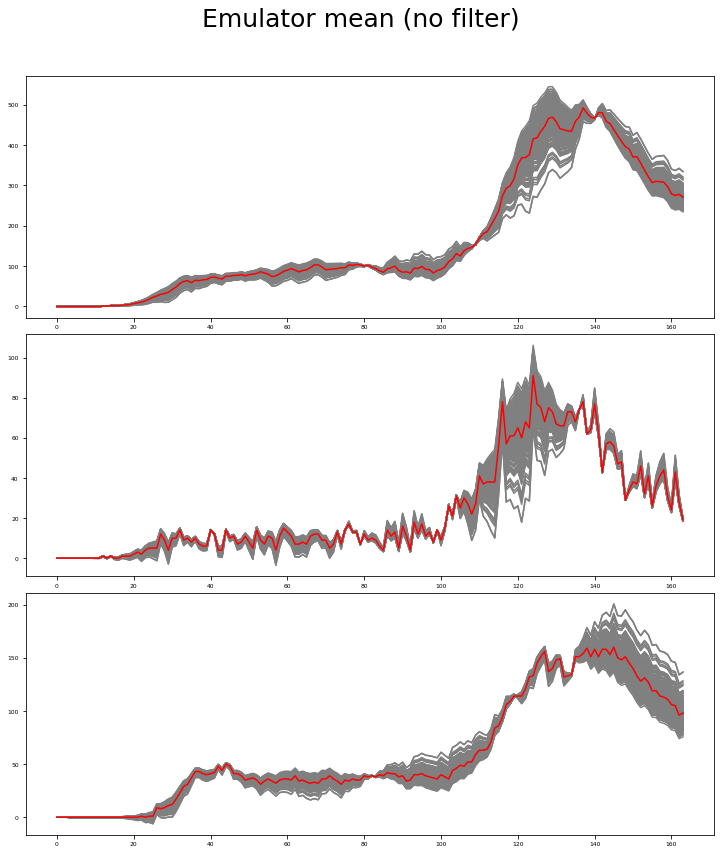

In [40]:
def plot_pred_mean(theta, xtot, emulator_model, pca_dict, title = None):
    '''
    Plots a list of profiles in the same figure. Each profile corresponds
    to a stochastic replica for the given instance.
    '''
    pcamat = pca_dict['pcamat']
    pcascale = pca_dict['pcascale']
    pcaoffset = pca_dict['pcaoffset']
    
    pred_model = emulator_model.predict(xtot, theta)
    pred_mean = pred_model.mean()

    fevalback = pred_mean.T @ np.linalg.pinv(pcamat)
    fevalback = np.multiply(fevalback, pcascale) + pcaoffset
      
    N = len(fevalback)
    fig, axs = plt.subplots(3, figsize=(10, 12))
    if title is not None:
        fig.suptitle(title, fontsize=25)

    T = int(492/3)
    for j in range(3):
        for i in range(N):
            axs[j].plot(range(T), fevalback[i,(j*T):(j*T + T)], color='grey')
        axs[j].plot(range(T), real_data[(j*T):(j*T + T)], color='red')
    fig.tight_layout()
    fig.subplots_adjust(top=0.9)    
    plt.show()
    
plot_pred_mean(param_values, xtot, emulator_nofilter, pca_dict, title='Emulator mean (no filter)')

In [36]:
print(np.shape(pca_dict['pcamat']))

(492, 10)
